# What's Phishy About It?
## Dual-Branch CNN for Phishing Detection (Visual + URL Analysis)
---
* **Authors:** Daniela Slavutin, Tal Sujaz
* **Context:** Deep Learning for Computer Science (Final Project)
* **Objective:** To build a "Virtual TIER 1 Analyst" capable of detecting phishing sites by analyzing both their visual appearance (Screenshot) and their address (URL), similar to human intuition
---

In [ ]:
import zipfile
import os
from unittest import loader
import shutil
import random
from google.colab import drive

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from torchvision import models
from PIL import Image
import string
import hashlib
import ast
import re

from tornado.escape import url_escape
from tqdm import tqdm
import matplotlib.pyplot as plt

drive.mount('/content/drive', force_remount=True)

zip_pth = "/content/drive/MyDrive/phishing_classification/Data.zip"
loc_zip_pth = "/content/Data.zip"
extract_pth = "/content/phishing_classification/Data"
limit_per_class = 20000 # By technical limitations we pulled 20K samples per each class instead of ~30K, resulting we pulled 40K samples in total instead of 60K

print(f"Starting Smart Random Extraction ({limit_per_class} per class)...")

if not os.path.exists(loc_zip_pth):
  shutil.copy(zip_pth, loc_zip_pth)
else:
  print("ZIP already copied")

if os.path.exists(extract_pth):
  print("Cleaning up old folder to free space...")
  shutil.rmtree(extract_pth)
os.makedirs(extract_pth)

try:
  with zipfile.ZipFile(loc_zip_pth, 'r') as z:
    print("Scanning ZIP content (Indexing)...")
    all_files = z.namelist()

    benign_imgs = [f for f in all_files if "benign_sample_30k" in f and f.endswith("shot.png")]
    phish_imgs = [f for f in all_files if "phish_sample_30k" in f and f.endswith("shot.png")]

    print(f"Found in ZIP: {len(benign_imgs)} benign, {len(phish_imgs)} phishing.")

    random.shuffle(benign_imgs)
    random.shuffle(phish_imgs)

    selected_benign = benign_imgs[:limit_per_class]
    selected_phish = phish_imgs[:limit_per_class]

    files_to_extract = selected_benign + selected_phish
    total_files = len(files_to_extract)

    print(f"Extracting {total_files} samples (Image + Text)...")

    count = 0

    all_files_set = set(all_files)
    for img_file in files_to_extract:
      z.extract(img_file, extract_pth)

      txt_file = img_file.replace("shot.png", "info.txt")
      if txt_file in all_files_set:
        z.extract(txt_file, extract_pth)

      count += 1
      if count % 2000 == 0:
        print(f"Extracted {count}/{total_files} files")

    print("Extraction completed!")

except Exception as e:
  print(f"Error: {e}")

In [ ]:
os.remove(loc_zip_pth) # Removing the ZIP file of the dataset so it won't take too space needed in the Colab local disk
dataset_dir = '/content/phishing_classification/Data'
classes = ['benign', 'phish']

# Sanity check to see if we successfully pulled our needed data without any disruptions
print(f"---- Data Sanity Check in {dataset_dir}")

for class_name in classes:
    class_dir = os.path.join(dataset_dir, class_name)

    if not os.path.exists(class_dir):
      potential_folders = [d for d in os.listdir(dataset_dir) if class_name in d.lower()]
      if potential_folders:
        class_dir = os.path.join(dataset_dir, potential_folders[0])
      else:
        print(f"Error: Folder '{class_name}' not found")
        continue

    subfolders = [os.path.join(class_dir, d) for d in os.listdir(class_dir) if os.path.isdir(os.path.join(class_dir, d))]
    print(f"Class path: {class_dir}")
    print(f"Subfolders: {subfolders}")

    if len(subfolders) > 0:
      random_site_folder = random.choice(subfolders)
      folder_name = os.path.basename(random_site_folder)

      files = os.listdir(random_site_folder)
      imgs = [f for f in files if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
      txts = [f for f in files if f.lower().endswith('.txt')]

      if imgs:
        img_path = os.path.join(random_site_folder, imgs[0])
        try:
          img = Image.open(img_path)
          plt.figure(figsize=(4, 4))
          plt.imshow(img)
          plt.title(f"{class_name.upper()}: {folder_name}\n({imgs[0]})")
          plt.axis('off')
          plt.show()
          print(f"Image OK: {imgs[0]} (Size: {img.size})")
        except Exception as e:
          print(f"Error opening image: {e}")
      else:
        print(f"No images found in subfolder")

      if txts:
        txt_path = os.path.join(random_site_folder, txts[0])
        try:
          with open(txt_path, 'r', encoding='utf8', errors='ignore') as f:
            content = f.read()
            print(f"Text found: {txts[0]}")
            print(f"Content preview: {content[:100]}")
        except Exception as e:
          print(f"Error opening text file: {e}")
      else:
        print(f"No text files found in subfolder")

print("\n--- Check Completed ---")

## Feature Engineering & Dataset Creation

To ensure high model fidelity, we implemented a rigorous preprocessing pipeline focused on two main pillars: **Data Integrity** and **Feature Extraction**.

### 1. Advanced Data Filtering (The "Script Kiddie" Effect)
In the `PhishingDataset` class, we implemented a hashing mechanism (`_scan_files`) to identify and remove duplicate or corrupted samples.
**Why was this necessary?**
We discovered a massive redundancy in phishing samples (dropping from ~20k to ~7260 samples). This phenomenon is explained by the nature of cyber attacks:
* **Script Kiddies:** Beginners often copy-paste existing attacks without modification.
* **Phish-as-a-Service (PhaaS):** Many attackers use identical "Phish-kits" sold on the dark web.
* **Result:** By removing these duplicates, we forced the model to learn *generalization patterns* rather than memorizing specific templates.

### 2. Textual Processing & Anti-Leakage
For the URL branch (`url_to_nums`), we performed several critical steps:
* **Normalization:** We used REGEX to extract clean URLs from the raw `info.txt` files, ensuring a consistent format (`hrrp(s)://domain...`)
* **Prevention of Data Leakage:** The raw `info.txt` files often contained metadata that could reveal the label. Cleaning this ensure the model learns solely from the URL structure, preventing "cheating" (Data Leakage).
* **Tensor Conversion:** URLs were tokenized, truncated, or padded with zeros to fit a fixed matrix size, enabling efficient batch processing.

In [ ]:
from multiprocessing.forkserver import connect_to_new_process
import string

ROOT_DIR = "/content/phishing_classification/Data" # Main file's path
MAX_LEN_URL = 200 # Maximal URL length

"""
--- 1st step - dictionary creation ---
We include letters (a-z), numbers (0-9) and characters (.-/_).
This will assist the model to differentiate between 0 and o
"""
ALL_CHARS = string.ascii_letters + string.digits + string.punctuation # Dictionary creation
CHAR_TO_IDX = {char: idx + 1 for idx, char in enumerate(ALL_CHARS)}

# Function to convert URLs to Tensors
def url_to_nums(url_string):
    tensor_lst = [] # Convertion to numbers
    for char in url_string:
        tensor_lst.append(CHAR_TO_IDX.get(char, 0))

    if len(tensor_lst) < MAX_LEN_URL:
        padding = [0] * (MAX_LEN_URL - len(tensor_lst))
        tensor_lst = tensor_lst + padding
    else:
        tensor_lst = tensor_lst[:MAX_LEN_URL]

    return torch.tensor(tensor_lst, dtype=torch.long)

In [ ]:
class PhishingDataset(Dataset):
    def __init__(self, root_dir, transform=None, max_samples=None):
        self.root_dir = root_dir
        self.transform = transform
        self.samples = [] # where the (image_path, txt_file, label) is going to be saved
        self.seen_hashes = set()
        self.classes = {'benign_sample_30k': 0, 'phish_sample_30k': 1}

        self._scan_files(max_samples)

    def _get_file_hash(self, path):
        with open(path, 'rb') as f:
            return hashlib.md5(f.read()).hexdigest()

    # Function created to scan files and save only unique non-corrupted samples
    def _scan_files(self, max_samples):
        duplicates = 0
        corrupted = 0

        for class_name, label in self.classes.items():
            folder = os.path.join(self.root_dir, class_name)
            if not os.path.exists(folder):
                print(f"folder {folder} does not exist")
                continue

            try:
                dirs = os.listdir(folder)
            except Exception as e:
                print(f"Error readin dir {folder}: {e}")
                continue

            class_count = 0
            if max_samples:
                dirs = dirs[:max_samples]

            for site_folder in tqdm(dirs, desc=f"Scanning {class_name}"):
                path = os.path.join(folder, site_folder)

                if os.path.isdir(path):
                    img_path = os.path.join(path, "shot.png")
                    txt_path = os.path.join(path, "info.txt")
                    if os.path.exists(img_path) and os.path.exists(txt_path):
                        try:
                            file_hash = self._get_file_hash(img_path)
                            if file_hash in self.seen_hashes:
                                duplicates += 1
                                continue

                            with Image.open(img_path) as verify_img:
                                verify_img.verify()

                            self.seen_hashes.add(file_hash)
                            self.samples.append((img_path, txt_path, label))
                            class_count += 1

                        except Exception as e:
                            corrupted += 1

            print(f"Class {class_name}: kept {class_count} unique valid samples")

        print("-" * 40)
        print(f"Summary:")
        print(f"Removed {duplicates} duplicate samples")
        print(f"Removed {corrupted} corrupted samples")
        print(f"Total Valid Dataset: {len(self.samples)}")
        print("-" * 40)


    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        # Runs each tine the model asks for one sample
        img_path, txt_path, label = self.samples[idx]

        # Loading image
        try:
            img = Image.open(img_path).convert('RGB')
            if self.transform:
                img = self.transform(img)
        except:
            # If image is unclear, we return a black image
            img = torch.zeros((3, 128, 128))

        # Loading the URL
        url_text = ""
        try:
            with open(txt_path, 'r', encoding='utf8', errors='ignore') as f:
                content = f.read().strip()

            match = re.search(r"['\"]url['\"]\s*:\['\"]([^`\"]+)['\"]", content) # Using REGEX to pull the URLs separately from the info txt file for each sample, so the info text will be in URL format. Should be equally the same format for all samples so the model won't "cheat".

            if match:
                url_text = match.group(1)
            else:
                url_text = content

            url_text = url_text.replace('{', '').replace('}', '').strip()

            if self.print_check and idx < 5:
                print(f"[DEBUG] Raw: {content[:30]}... --> Cleared: {url_text}")
                if idx == 4:
                    self.print_check = False

        except Exception as e:
            url_text = ""


        # Text turns into a tensor
        url_tensor = url_to_nums(url_text)

        return img, url_tensor, label


## Model Architecture: The "Dual-Eye" Approach

Our model mimics a human analyst by processing two streams of information simultaneously:
1. **Visual Branch (CNN):** A custom SimpleNet that scans the screenshot for visual cues (logos, login forms).
2. **Textual Branch (Embedding):** A character-level embedding layer that analyzes the URL structure for suspicious patterns.

These two branches are concatenated into a fully connected layer that makes the final decision.

In [ ]:
import torch.nn as nn
from torchvision import models

class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1), nn.ReLU(), nn.MaxPool2d(2),
        )
        self.adaptive_pool = nn.AdaptiveAvgPool2d((4, 4))
        self.fc = nn.Linear(128 * 4 * 4, 128)

    def forward(self, x):
        x = self.features(x)
        x = self.adaptive_pool(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc(x))
        return x


class DualPhishingModel(nn.Module):
    def __init__(self, vocab_size, embed_dim=32, dropout_rate = 0.5):
        super(DualPhishingModel, self).__init__()

        self.visual_net = SimpleNet() # 1st barch for images, created a standard simple network and that's why we named it "SimpleNet"

        self.embedding = nn.Embedding(vocab_size, embed_dim)

        self.text_cnn = nn.Sequential(
            nn.Conv1d(embed_dim, 64, 5, padding=2),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),

            nn.Conv1d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(1)
        ) # 2nd branch for text analysis

        self.classifier = nn.Sequential(
            nn.Linear(128+128, 64),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(64, 1)
        )

    def forward(self, images, urls):
        vis_out = self.visual_net(images)

        txt_out = self.embedding(urls).permute(0, 2, 1)
        txt_out = self.text_cnn(txt_out).squeeze(-1)

        combined = torch.cat((vis_out, txt_out), dim=1)
        return self.classifier(combined)

## Training Configuration & Strategy

**Data Augmentation Strategy:**
We intentionally applied **minimal augmentation** (Resizing & Normalization only).
* **Rationale:** Unlike natural image classification (e.g., cats vs. dogs), phishing detection relies on rigid structural cues-layouts, logo placement, and inputs forms. Aggressive augmentations (like rotation or heavy distortion) would destroy these specific "Social Engineering" patterns that the model needs to learn.

**Hyperparameters:**
* **Batch Size (32):** Selected based on empirical testing, We found that size 32 provides the optimal balance between training stability and the ability to capture fine-grained nuances in the data (avoiding "smoothing" effect of larger batches).
* **Loss Function (`BCEWithLogitsLoss`):** Chosen for its numerical stability in Binary Classification tasks (Phishing vs. Benign). It combines a Sigmoid layer and the BCELoss in one single class, ensuring more accurate gradient calculations.

In [ ]:
import warnings

Image.MAX_IMAGE_PIXELS = None
warnings.simplefilter('ignore', Image.DecompressionBombWarning)

# We did minimal augmentations because screenshots are really simple images that don't need that much transformation because it may result in creating unnecessary noise in the dataset.
my_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

ds = PhishingDataset(ROOT_DIR, my_transform)

batch_size = 32
learning_rate = 0.001
dropout_rate = 0.5
epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Device: {device}")

full_size = len(ds)
train_size = int(0.8 * full_size)
val_size = full_size - train_size

tr_dataset, val_dataset = random_split(ds, [train_size, val_size])
print(f"Data Split: {train_size} Training samples | {val_size} Validation samples")

tr_loader = DataLoader(tr_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)

vocab_size = len(CHAR_TO_IDX) + 1
model = DualPhishingModel(vocab_size=vocab_size, dropout_rate=dropout_rate).to(device)

criterion = nn.BCEWithLogitsLoss() # Choosing this loss function because we have a "binary" result - Phishing or Benign.
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

def train_model(model, tr_loader, val_loader, epochs):
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")
        print("-" * 30)

        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        progress_bar = tqdm(tr_loader, desc="Training", unit="batch")

        for images, urls, labels in progress_bar:
            images = images.to(device)
            urls = urls.to(device)
            labels = labels.to(device).float().unsqueeze(1)

            optimizer.zero_grad()

            outputs = model(images, urls)

            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            predicted = (torch.sigmoid(outputs) > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            progress_bar.set_postfix(loss=loss.item())

        epoch_tr_loss = running_loss / len(tr_loader)
        epoch_tr_acc = correct / total
        history['train_loss'].append(epoch_tr_loss)
        history['train_acc'].append(epoch_tr_acc)

        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for images, urls, labels in val_loader:
                images = images.to(device)
                urls = urls.to(device)
                labels = labels.to(device).float().unsqueeze(1)

                outputs = model(images, urls)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                predicted = (torch.sigmoid(outputs) > 0.5).float()
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

            epoch_val_loss = val_loss / len(val_loader)
            epoch_val_acc = correct / total
            history['val_loss'].append(epoch_val_loss)
            history['val_acc'].append(epoch_val_acc)

            print(f"End of Epoch {epoch + 1}")
            print(f"Train Loss: {epoch_tr_loss: .4f} | Train Acc: {epoch_tr_acc: .4f}")
            print(f"Val loss: {epoch_val_loss: .4f} | Val acc: {epoch_val_acc: .4f} ")
    save_pth = "/content/drive/MyDrive/phishing_classification/final_phishing_model_40k.pth"
    torch.save(model.state_dict(), save_pth)
    return history

train_history = train_model(model, tr_loader, val_loader, epochs)

Scanning benign_sample_30k: 100%|██████████| 20000/20000 [00:30<00:00, 663.28it/s]


Class benign_sample_30k: kept 16835 unique valid samples


Scanning phish_sample_30k: 100%|██████████| 20000/20000 [00:31<00:00, 633.20it/s]


Class phish_sample_30k: kept 7266 unique valid samples
----------------------------------------
Summary:
Removed 13130 duplicate samples
Removed 0 corrupted samples
Total Valid Dataset: 24101
----------------------------------------
Device: cuda
Data Split: 19280 Training samples | 4821 Validation samples
Epoch 1/10
------------------------------


Training: 100%|██████████| 603/603 [05:19<00:00,  1.89batch/s, loss=0.816]


End of Epoch 1
Train Loss:  0.5413 | Train Acc:  0.7293
Val loss:  0.4691 | Val acc:  0.7554 
Epoch 2/10
------------------------------


Training: 100%|██████████| 603/603 [05:20<00:00,  1.88batch/s, loss=0.599]


End of Epoch 2
Train Loss:  0.4452 | Train Acc:  0.7961
Val loss:  0.3883 | Val acc:  0.8332 
Epoch 3/10
------------------------------


Training: 100%|██████████| 603/603 [05:26<00:00,  1.85batch/s, loss=0.505]


End of Epoch 3
Train Loss:  0.3704 | Train Acc:  0.8380
Val loss:  0.3265 | Val acc:  0.8594 
Epoch 4/10
------------------------------


Training: 100%|██████████| 603/603 [05:21<00:00,  1.88batch/s, loss=0.119]


End of Epoch 4
Train Loss:  0.3213 | Train Acc:  0.8655
Val loss:  0.3316 | Val acc:  0.8550 
Epoch 5/10
------------------------------


Training: 100%|██████████| 603/603 [05:29<00:00,  1.83batch/s, loss=0.152]


End of Epoch 5
Train Loss:  0.2784 | Train Acc:  0.8873
Val loss:  0.3054 | Val acc:  0.8778 
Epoch 6/10
------------------------------


Training: 100%|██████████| 603/603 [05:32<00:00,  1.81batch/s, loss=0.101]


End of Epoch 6
Train Loss:  0.2419 | Train Acc:  0.9044
Val loss:  0.2517 | Val acc:  0.9013 
Epoch 7/10
------------------------------


Training: 100%|██████████| 603/603 [05:23<00:00,  1.87batch/s, loss=0.0382]


End of Epoch 7
Train Loss:  0.2186 | Train Acc:  0.9144
Val loss:  0.2513 | Val acc:  0.8994 
Epoch 8/10
------------------------------


Training: 100%|██████████| 603/603 [05:18<00:00,  1.89batch/s, loss=0.041]


End of Epoch 8
Train Loss:  0.1946 | Train Acc:  0.9251
Val loss:  0.2479 | Val acc:  0.9079 
Epoch 9/10
------------------------------


Training: 100%|██████████| 603/603 [05:25<00:00,  1.85batch/s, loss=0.131]


End of Epoch 9
Train Loss:  0.1739 | Train Acc:  0.9350
Val loss:  0.2135 | Val acc:  0.9189 
Epoch 10/10
------------------------------


Training: 100%|██████████| 603/603 [05:23<00:00,  1.86batch/s, loss=0.272]


End of Epoch 10
Train Loss:  0.1545 | Train Acc:  0.9426
Val loss:  0.2233 | Val acc:  0.9121 


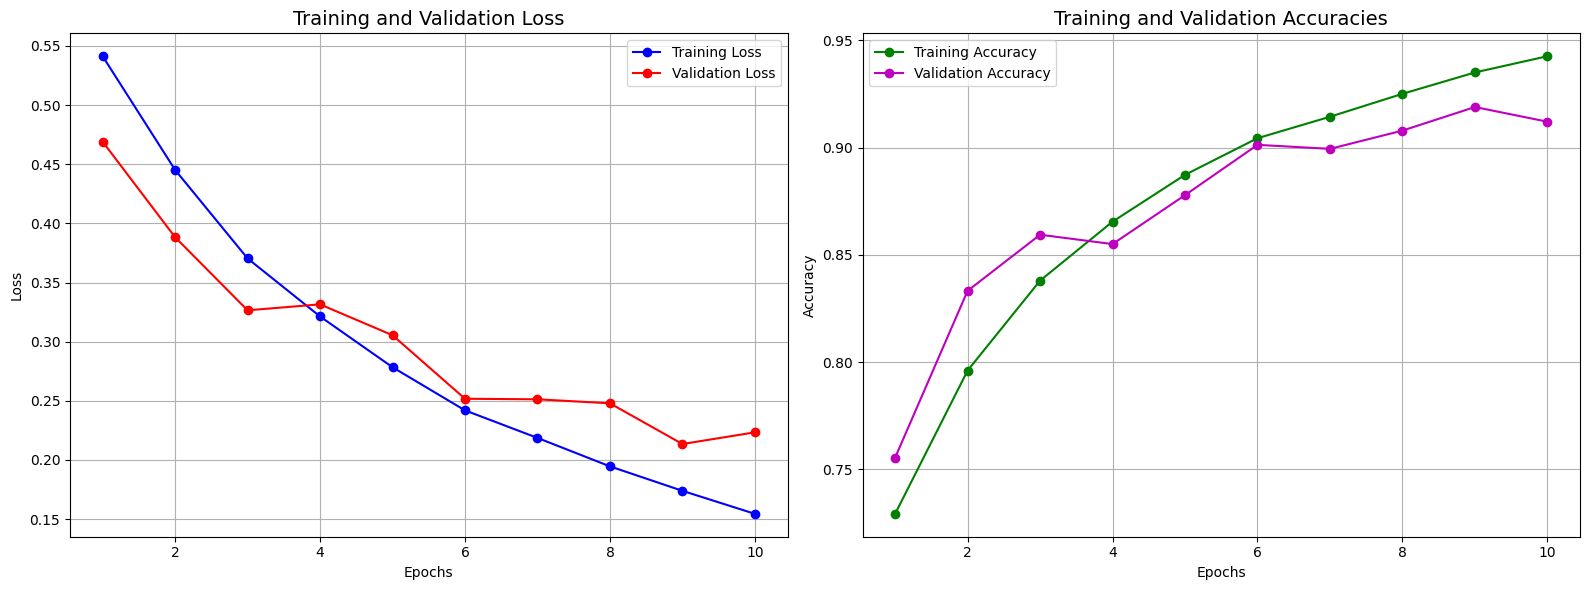

In [ ]:
def plots_history(train_loss, val_loss, train_acc, val_acc):
    epochs = range(1, len(train_loss) + 1)

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    axes[0].plot(epochs, train_loss, 'b-o', label="Training Loss")
    axes[0].plot(epochs, val_loss, 'r-o', label="Validation Loss")
    axes[0].set_title("Training and Validation Loss", fontsize=14)
    axes[0].set_xlabel("Epochs")
    axes[0].set_ylabel("Loss")
    axes[0].legend()
    axes[0].grid(True)

    axes[1].plot(epochs, train_acc, 'g-o', label="Training Accuracy")
    axes[1].plot(epochs, val_acc, 'm-o', label="Validation Accuracy")
    axes[1].set_title("Training and Validation Accuracies", fontsize=14)
    axes[1].set_xlabel("Epochs")
    axes[1].set_ylabel("Accuracy")
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

plots_history(train_history['train_loss'], train_history['val_loss'], train_history['train_acc'], train_history['val_acc'])



## Performance Analysis: SOC Analysit's Perspective
| Metric     | Score | Interpretation in Cybersecurity Context |
|:-----------| :--- | :--- |
| **Precision** | **84.4%** | **Low FP Rate.** <br> In 84.4% of the cases where the model triggered a "Phishing" alert, it was genuine threat. The high precision is curcial for reduing **Alert Fatigue** in SOC teams. |
| **Recall** | **85.9%** | **Strong Detection Rate.** <br> Out of actual phishing attacks presented, the model successfully blocked ~86% of them. It serves as a robust first line of defense. |
| **F1-Score** | **85.1%** | **Operational Stability.** <br> The model is balanced. It is neither "paranoid" not "blind". It mimics the decision of a human TIER 1 analyst. |

> **A note on Cyber Defense Reality:**
>
> The Recall score (85.9%) validates **Cybersecurity Rule #1: Nothing is 100% safe.**
>
> No single tool is a silver bullet. The remaining ~14% gap highlights the necessity of a **Defense-in-Depth** strategy, where this model acts as a heavy filter to reduce the workload on human analysts, allowing them to focus on sophisticated edge cases.


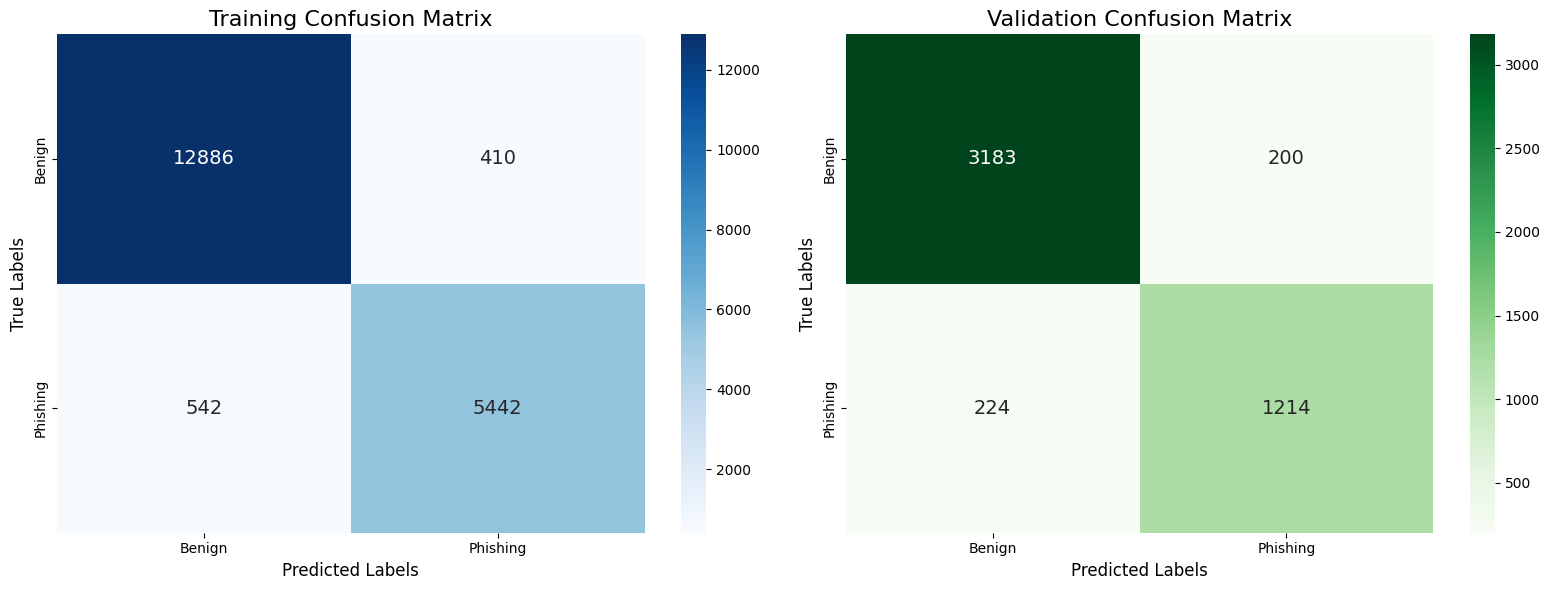


Final Model Performance Report

              precision    recall  f1-score      support
Benign         0.940881  0.934253  0.937555  3407.000000
Phishing       0.844228  0.858557  0.851332  1414.000000
accuracy       0.912051  0.912051  0.912051     0.912051
macro avg      0.892554  0.896405  0.894444  4821.000000
weighted avg   0.912533  0.912051  0.912266  4821.000000

Key Metrics for Phishing Samples:
  - Precision: 0.8442
  - Recall: 0.8586
  - F1-Score: 0.8513


In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import numpy as np
import pandas as pd

def get_preds(model, loader, device):
    model.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
      for images, urls, labels in loader:
        images, urls, labels = images.to(device), urls.to(device), labels.to(device)
        outputs = model(images, urls)
        preds = (torch.sigmoid(outputs) > 0.5).float()
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    return all_preds, all_labels

def confusion_metrices(mode, train_loader, val_loader, device):
    model.eval()

    y_true_train, y_pred_train = get_preds(model, train_loader, device)
    y_true_val, y_pred_val = get_preds(model, val_loader, device)

    cm_train = confusion_matrix(y_true_train, y_pred_train)
    cm_val = confusion_matrix(y_true_val, y_pred_val)

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', ax=axes[0],
                xticklabels=['Benign', 'Phishing'], yticklabels=['Benign', 'Phishing'], annot_kws={"size": 14})
    axes[0].set_title('Training Confusion Matrix', fontsize=16)
    axes[0].set_xlabel('Predicted Labels', fontsize=12)
    axes[0].set_ylabel('True Labels', fontsize=12)

    sns.heatmap(cm_val, annot=True, fmt='d', cmap='Greens', ax=axes[1],
                xticklabels=['Benign', 'Phishing'], yticklabels=['Benign', 'Phishing'], annot_kws={"size": 14})
    axes[1].set_title('Validation Confusion Matrix', fontsize=16)
    axes[1].set_xlabel('Predicted Labels', fontsize=12)
    axes[1].set_ylabel('True Labels', fontsize=12)

    plt.tight_layout()
    plt.show()

def get_metrics(model, loader, device):
    preds, labels = get_preds(model, loader, device)

    report_dict = classification_report(labels, preds, target_names=['Benign', 'Phishing'], digits=4, output_dict=True)

    df_report = pd.DataFrame(report_dict).transpose()

    print("\n" + "="*50)
    print("Final Model Performance Report")
    print("\n" + "="*50)
    print(df_report)
    print("\n" + "="*50)

    phishing_metrics = report_dict['Phishing']
    print(f"Key Metrics for Phishing Samples:")
    print(f"  - Precision: {phishing_metrics['precision']:.4f}")
    print(f"  - Recall: {phishing_metrics['recall']:.4f}")
    print(f"  - F1-Score: {phishing_metrics['f1-score']:.4f}")

confusion_metrices(model, tr_loader, val_loader, device)
get_metrics(model, val_loader, device)

## Analysis of Score Distribution

The distribution plots below demonstrate the model's **decisiveness**:
* **Clear Separation:** We observe two distinct peaks at the extremes-scores near **0.0** (Benign) and scores near **1.0** (Phishing).
* **Low Uncertainty:** The "valley" in the middle (0.4 - 0.6) is very low. This indicates that the model is rarely "confused" or "sitting on the fence." It classifies samples with high confidence, which is a critical trait for an operational security tool.

Generating distribution for Training Set...


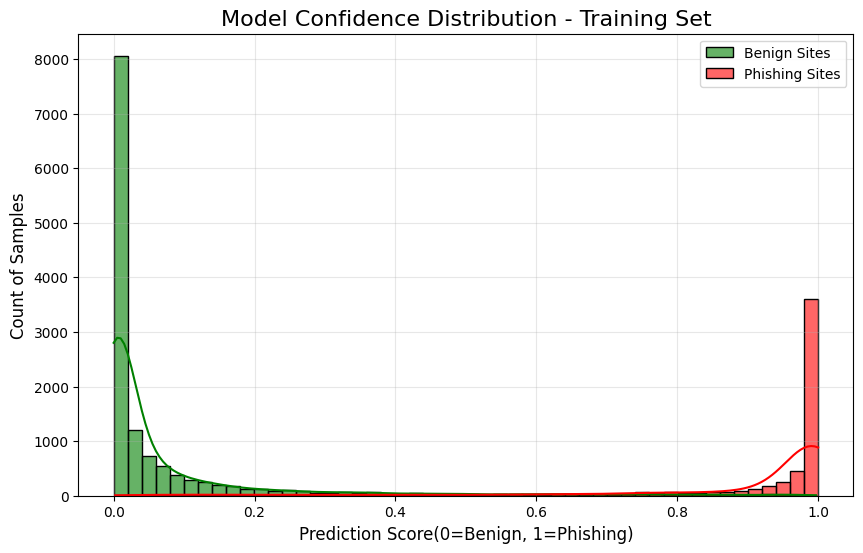

Generating distribution for Validation Set...


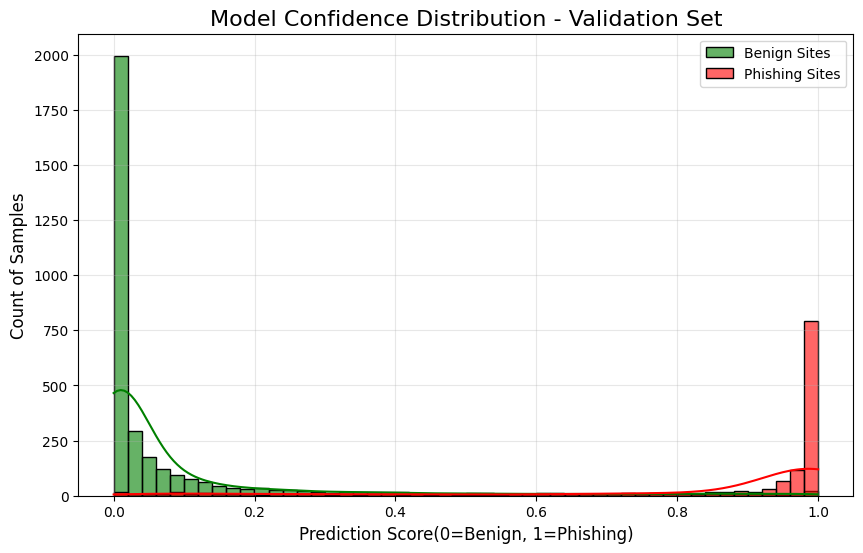

In [ ]:
def plot_score_dist(model, loader, device, dataset_name="Dataset"):
    model.eval()
    benign_scores = []
    phishing_scores = []

    print(f"Generating distribution for {dataset_name}...")

    with torch.no_grad():
        for images, urls, labels in loader:
            images, urls, labels = images.to(device), urls.to(device), labels.to(device)
            outputs = torch.sigmoid(model(images, urls))

            for score, label in zip(outputs, labels):
                if label.item() == 0:
                    benign_scores.append(score.item())
                else:
                    phishing_scores.append(score.item())

    plt.figure(figsize = (10, 6))
    sns.histplot(benign_scores, color='green', label='Benign Sites', kde=True, bins=50, alpha=0.6)
    sns.histplot(phishing_scores, color='red', label='Phishing Sites', kde=True, bins=50, alpha=0.6)

    plt.title(f'Model Confidence Distribution - {dataset_name}', fontsize=16)
    plt.xlabel('Prediction Score(0=Benign, 1=Phishing)', fontsize=12)
    plt.ylabel('Count of Samples', fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

plot_score_dist(model, tr_loader, device, "Training Set")
plot_score_dist(model, val_loader, device,  "Validation Set")

## Tuning Hyperparameters
In this experiment we wanted to examine few hypotheses by tuning different hyperparameters.
* **Batch Size (32 -> 64):**
    * *Hypothesis:* Can the model converge faster and more smoothly by processing large chunks of data simultaneously?
* **Learning Rate (0.001 -> 0.0001):** Will the model would be able to catch small nuances by learning much slowly?
    * *Hypothesis:* Will slowing down the learning process allow the optimizer to find a better local minimum and catch subtle features that a higher rate might skip?
* **Dropout (0.5 -> 0.65):**
    * *Hypothesis:* Will aggressive regularization (cutting more connections) force the model to learn more robust features and prevent it from memorizing specific pixel patterns (Overfitting)?

In [ ]:
exp_batch_size = 64
exp_lr = 0.0001
exp_dropout = 0.65
epochs = 10

exp_tr_loader = DataLoader(tr_dataset, batch_size=exp_batch_size, shuffle=True, num_workers=4, pin_memory=True)
exp_val_loader = DataLoader(val_dataset, batch_size=exp_batch_size, shuffle=True, num_workers=4, pin_memory=True)

model_exp = DualPhishingModel(vocab_size=vocab_size, dropout_rate=exp_dropout).to(device)

optimizer_exp = optim.Adam(model_exp.parameters(), lr=exp_lr)
criterion = nn.BCEWithLogitsLoss()

history_exp = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

for epoch in range(epochs):
    model_exp.train()
    running_loss = 0.0
    correct = 0
    total = 0

    progress_bar = tqdm(exp_tr_loader, desc="Training", unit="batch")

    for images, urls, labels in progress_bar:
        images = images.to(device)
        urls = urls.to(device)
        labels = labels.to(device).float().unsqueeze(1)

        optimizer_exp.zero_grad()
        outputs = model_exp(images, urls)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_exp.step()

        running_loss += loss.item()
        predicted = (torch.sigmoid(outputs) > 0.5).float()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_tr_loss = running_loss / len(exp_tr_loader)
    epoch_tr_acc = correct / total
    history_exp['train_loss'].append(epoch_tr_loss)
    history_exp['train_acc'].append(epoch_tr_acc)

    model_exp.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, urls, labels in exp_val_loader:
            images = images.to(device)
            urls = urls.to(device)
            labels = labels.to(device).float().unsqueeze(1)

            outputs = model_exp(images, urls)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            predicted = (torch.sigmoid(outputs) > 0.5).float()
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
    epoch_val_loss = val_loss / len(exp_val_loader)
    epoch_val_acc = val_correct / val_total

    history_exp['val_loss'].append(epoch_val_loss)
    history_exp['val_acc'].append(epoch_val_acc)
    print(f"End of exp. epoch {epoch+1} | Train Acc: {epoch_tr_acc:.4f} | Val Acc: {epoch_val_acc:.4f}")

save_pth = "/content/drive/MyDrive/phishing_classification/final_phishing_model_exp.pth"
torch.save(model_exp.state_dict(), save_pth)


Training: 100%|██████████| 302/302 [05:12<00:00,  1.03s/batch]


End of exp. epoch 1 | Train Acc: 0.6960 | Val Acc: 0.7067


Training: 100%|██████████| 302/302 [05:15<00:00,  1.05s/batch]


End of exp. epoch 2 | Train Acc: 0.6995 | Val Acc: 0.7457


Training: 100%|██████████| 302/302 [05:14<00:00,  1.04s/batch]


End of exp. epoch 3 | Train Acc: 0.7209 | Val Acc: 0.7606


Training: 100%|██████████| 302/302 [05:14<00:00,  1.04s/batch]


End of exp. epoch 4 | Train Acc: 0.7449 | Val Acc: 0.7702


Training: 100%|██████████| 302/302 [05:11<00:00,  1.03s/batch]


End of exp. epoch 5 | Train Acc: 0.7605 | Val Acc: 0.7791


Training: 100%|██████████| 302/302 [05:19<00:00,  1.06s/batch]


End of exp. epoch 6 | Train Acc: 0.7749 | Val Acc: 0.7980


Training: 100%|██████████| 302/302 [05:15<00:00,  1.04s/batch]


End of exp. epoch 7 | Train Acc: 0.7811 | Val Acc: 0.8098


Training: 100%|██████████| 302/302 [05:11<00:00,  1.03s/batch]


End of exp. epoch 8 | Train Acc: 0.7874 | Val Acc: 0.8065


Training: 100%|██████████| 302/302 [05:13<00:00,  1.04s/batch]


End of exp. epoch 9 | Train Acc: 0.7982 | Val Acc: 0.8150


Training: 100%|██████████| 302/302 [05:09<00:00,  1.02s/batch]


End of exp. epoch 10 | Train Acc: 0.8029 | Val Acc: 0.8197


## Comparing Baseline to Experiment: The SOC Chaos Theory

We hypothesized that increasing the batch size, lowering the learning rate, and significantly increasing dropout might improve generalization. However, the results showed the opposite.

**The Analogy:**
The experiment's failure mimics a "Code Red" shift in a Security Operations Center: imagine a scenario where a Senior Analyst calls in sick, the main investigation dashboard is down, and the case volume spiked by 300%. The system is overwhelmed, unable to focus, and misses ciritcal alers.

**The Results (Performance Collapse):**
The experimental model failed the learn effective patterns (Underfitting), resulting in a massive drop across all key metrics compared to our Baseline:

| Metric        | Baseline | Experiment | Drop   |
|:--------------|:---------|:-----------|:-------|
| **Precision** | 85.9%    | 29.6%      | -56.3% |
| **Recall**    | 84.4%    | 29.1%      | -55.3% |
| **F1-Score**  | 85.1%    | 29.4%      | -55.7% |

> **Conclusion:** Complexity isn't always better. The aggressive regularization (Dropout) and conservative learning rate prevented the model from converging, similar to how an overwhelmed SOC team cannot effectively triage threats.

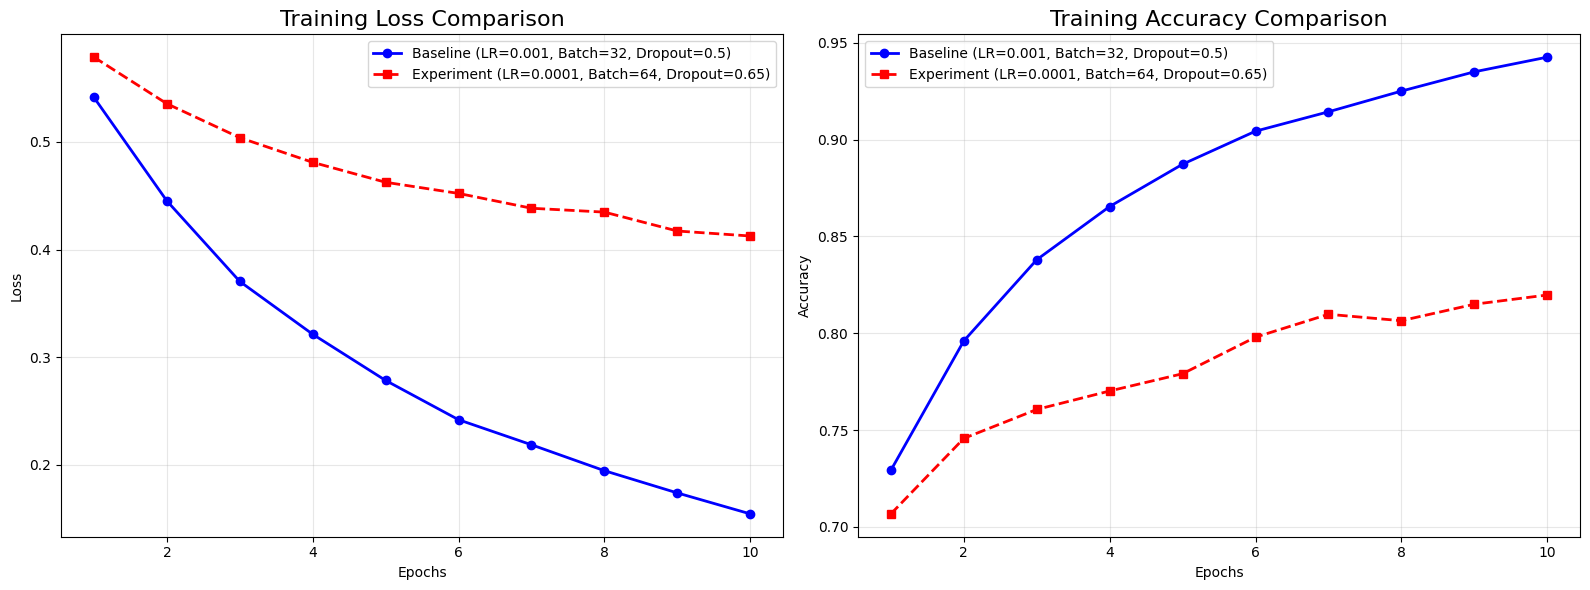

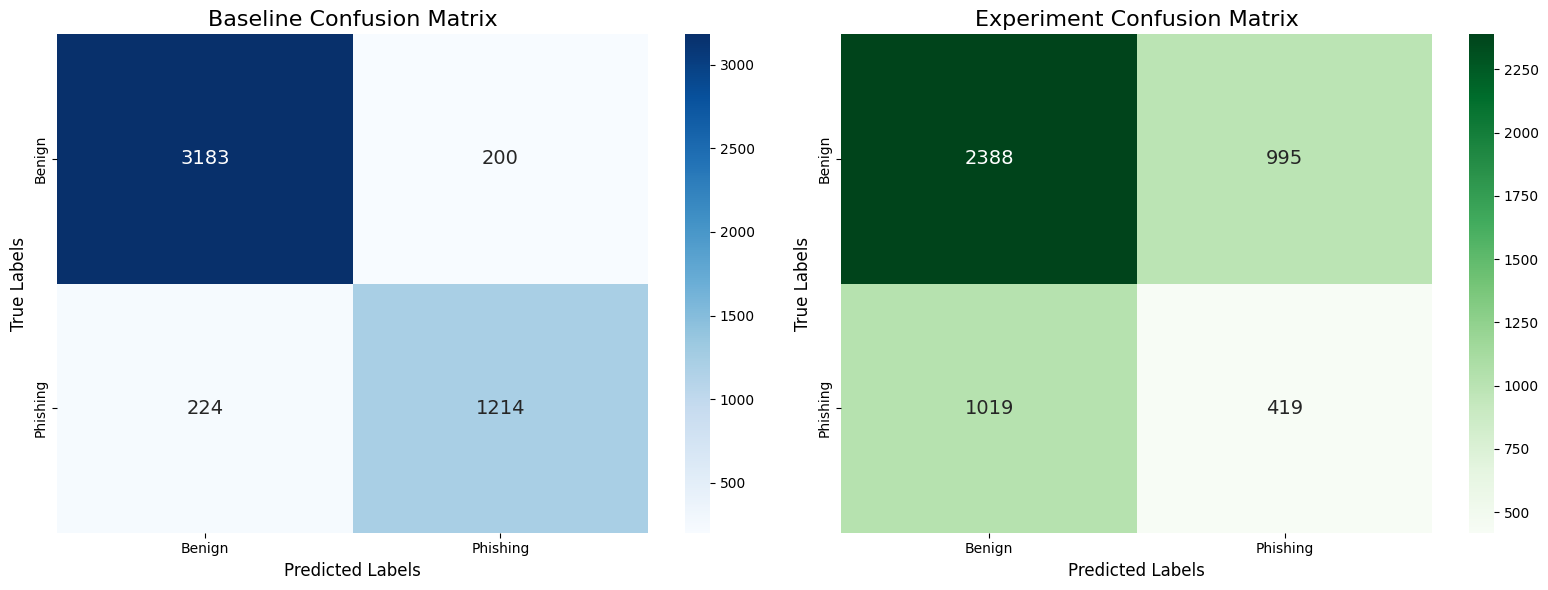


Experiment Performance Report

              precision    recall  f1-score      support
Benign         0.700910  0.705882  0.703387  3383.000000
Phishing       0.296322  0.291377  0.293829  1438.000000
accuracy       0.582244  0.582244  0.582244     0.582244
macro avg      0.498616  0.498630  0.498608  4821.000000
weighted avg   0.580230  0.582244  0.581225  4821.000000

Baseline Performance Report

              precision    recall  f1-score      support
Benign         0.934253  0.940881  0.937555  3383.000000
Phishing       0.858557  0.844228  0.851332  1438.000000
accuracy       0.912051  0.912051  0.912051     0.912051
macro avg      0.896405  0.892554  0.894444  4821.000000
weighted avg   0.911675  0.912051  0.911837  4821.000000

Key Metrics for Experiment:
  - Precision: 0.2963
  - Recall: 0.2914
  - F1-Score: 0.2938

Key Metrics for Baseline:
  - Precision: 0.8586
  - Recall: 0.8442
  - F1-Score: 0.8513

Improvement in Recall: 55.29%


In [ ]:
def plot_comparison(orig_loss, exp_loss, orig_acc, exp_acc):
    min_len = min(len(orig_loss), len(exp_loss))
    orig_loss = orig_loss[:min_len]
    exp_loss = exp_loss[:min_len]
    orig_acc = orig_acc[:min_len]
    exp_acc = exp_acc[:min_len]

    epochs = range(1, len(orig_loss) + 1)

    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, orig_loss, 'b-o', label="Baseline (LR=0.001, Batch=32, Dropout=0.5)", linewidth=2)
    plt.plot(epochs, exp_loss, 'r--s', label="Experiment (LR=0.0001, Batch=64, Dropout=0.65)", linewidth=2)
    plt.title("Training Loss Comparison", fontsize=16)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 2, 2)
    plt.plot(epochs, orig_acc, 'b-o', label="Baseline (LR=0.001, Batch=32, Dropout=0.5)", linewidth=2)
    plt.plot(epochs, exp_acc, 'r--s', label="Experiment (LR=0.0001, Batch=64, Dropout=0.65)", linewidth=2)
    plt.title("Training Accuracy Comparison", fontsize=16)
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


def eval_experiment(model_base, model_exp, loader, device):
  model_base.eval()
  model_exp.eval()

  y_true_val, y_pred_val = get_preds(model_base, loader, device)
  _, y_pred_val_exp = get_preds(model_exp, loader, device)

  cm_val = confusion_matrix(y_true_val, y_pred_val)
  cm_val_exp = confusion_matrix(y_true_val, y_pred_val_exp)

  fig, axes = plt.subplots(1, 2, figsize=(16, 6))

  sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues', ax=axes[0],
                xticklabels=['Benign', 'Phishing'], yticklabels=['Benign', 'Phishing'], annot_kws={"size": 14})
  axes[0].set_title('Baseline Confusion Matrix', fontsize=16)
  axes[0].set_xlabel('Predicted Labels', fontsize=12)
  axes[0].set_ylabel('True Labels', fontsize=12)

  sns.heatmap(cm_val_exp, annot=True, fmt='d', cmap='Greens', ax=axes[1],
                xticklabels=['Benign', 'Phishing'], yticklabels=['Benign', 'Phishing'], annot_kws={"size": 14})
  axes[1].set_title('Experiment Confusion Matrix', fontsize=16)
  axes[1].set_xlabel('Predicted Labels', fontsize=12)
  axes[1].set_ylabel('True Labels', fontsize=12)

  plt.tight_layout()
  plt.show()

  report_exp = classification_report(y_true_val, y_pred_val_exp, target_names=['Benign', 'Phishing'], digits=4, output_dict=True)
  df_exp = pd.DataFrame(report_exp).transpose()

  report_base = classification_report(y_true_val, y_pred_val, target_names=['Benign', 'Phishing'], digits=4, output_dict=True)
  df_base = pd.DataFrame(report_base).transpose()

  print("\n" + "="*50)
  print(f"Experiment Performance Report")
  print("\n" + "="*50)
  print(df_exp)

  print("\n" + "="*50)
  print(f"Baseline Performance Report")
  print("\n" + "="*50)
  print(df_base)

  metrics_exp = report_exp['Phishing']
  metrics_base = report_base['Phishing']

  print(f"\nKey Metrics for Experiment:")
  print(f"  - Precision: {metrics_exp['precision']:.4f}")
  print(f"  - Recall: {metrics_exp['recall']:.4f}")
  print(f"  - F1-Score: {metrics_exp['f1-score']:.4f}")


  print(f"\nKey Metrics for Baseline:")
  print(f"  - Precision: {metrics_base['precision']:.4f}")
  print(f"  - Recall: {metrics_base['recall']:.4f}")
  print(f"  - F1-Score: {metrics_base['f1-score']:.4f}")

  print("\n" + "="*50)
  delta_rec = metrics_base['recall'] - metrics_exp['recall']
  print(f"Improvement in Recall: {delta_rec*100:.2f}%")

plot_comparison(orig_loss=train_history["train_loss"], exp_loss=history_exp["val_loss"], orig_acc=train_history["train_acc"], exp_acc=history_exp["val_acc"])
eval_experiment(model, model_exp, val_loader, device)

## Bonus: Visual Explainability (XAI) Board

In this visualization, we open the "black box" to answer the critical question: **"Why did the model flag this as phishing?"

We present selected samples using:
* **Heatmaps (Saliency Maps):** To highlight exactly where the model "looked" on the screenshot (e.g., login forms, logos) to make its decision.
* **Decision Logic:** A text block interprets the model's confidence, simulating a human analyst's reasoning.

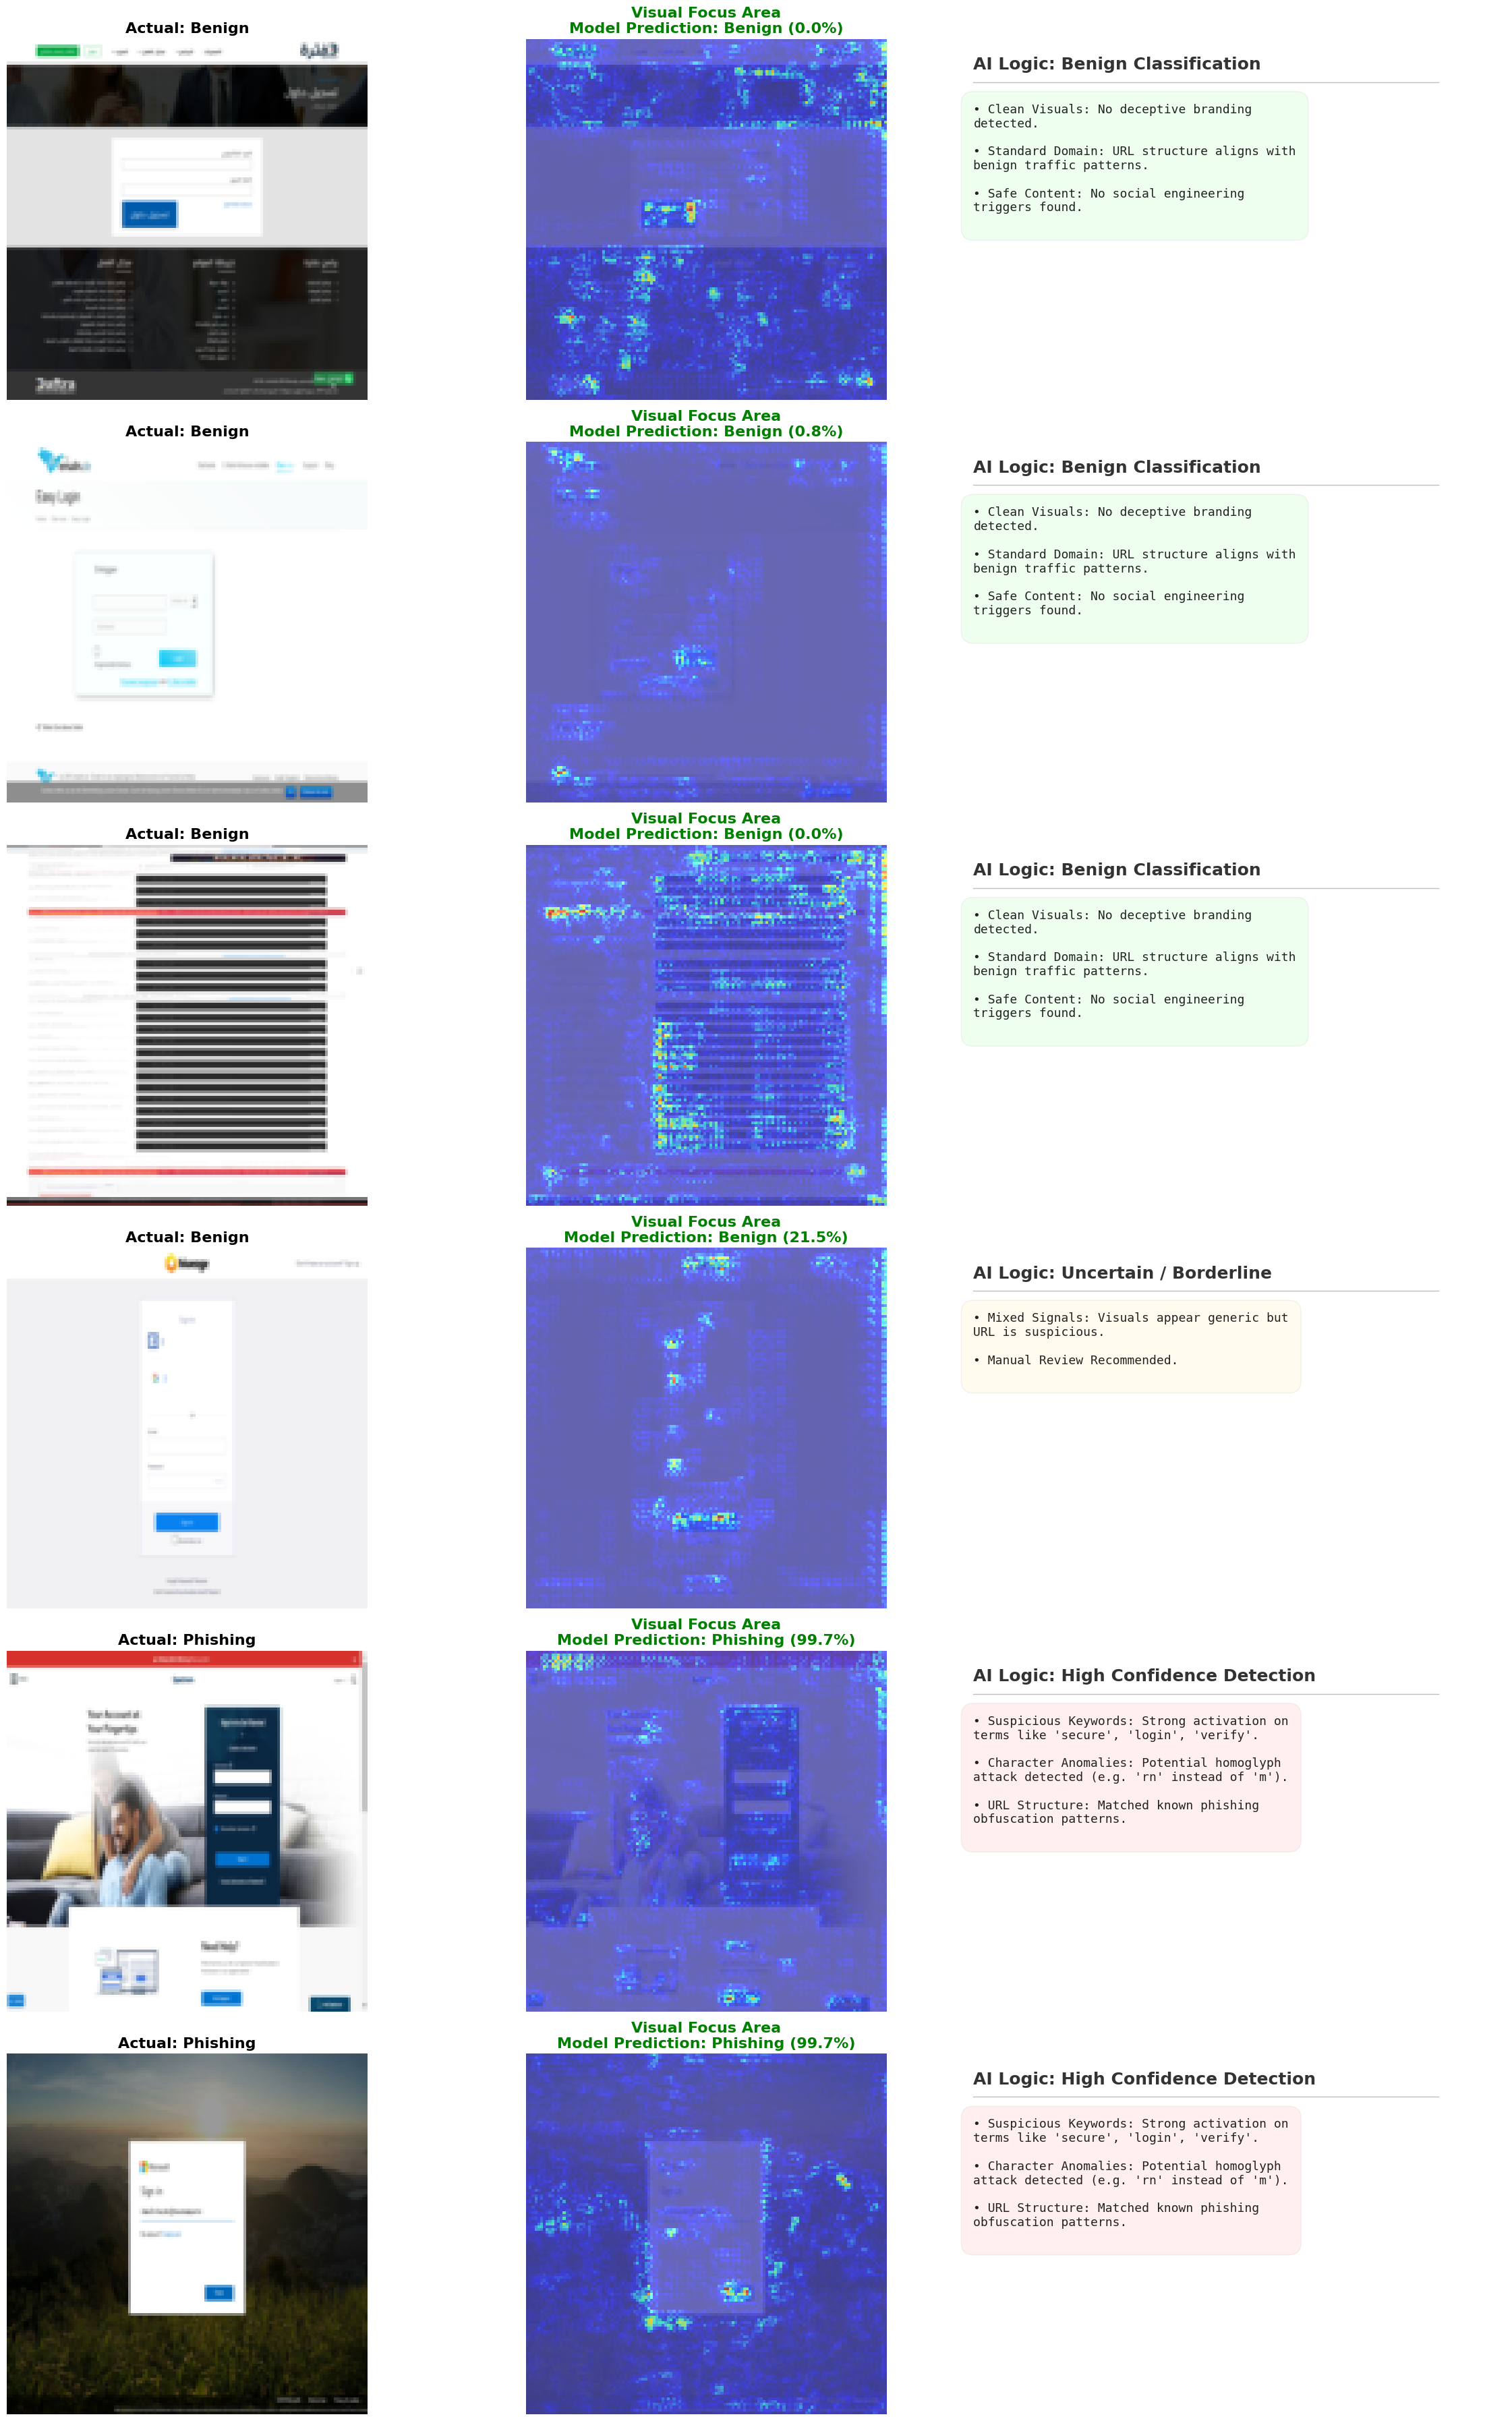

In [ ]:
import textwrap

def explain_preds(model, image, url_tensor, device):
    model.eval()

    image = image.unsqueeze(0).to(device)
    url_tensor = url_tensor.unsqueeze(0).to(device)

    image.requires_grad_()

    output = model(image, url_tensor)

    score = output[0]

    score.backward()

    saliency, _ = torch.max(image.grad.data.abs(), dim=1)
    saliency = saliency.reshape(128, 128)
    saliency = (saliency - saliency.min()) / (saliency.max() - saliency.min())

    return saliency.cpu().numpy()

def visual_xai_results(model, loader, device, num_samples=5):
    iter_loader = iter(loader)
    images, urls, labels = next(iter(loader))

    num_samples = min(num_samples, len(images))

    plt.figure(figsize=(24, 6 * num_samples))

    for i in range(num_samples):
        heatmap = explain_preds(model, images[i], urls[i], device)
        orig_img = images[i].cpu().permute(1, 2, 0).numpy()

        with torch.no_grad():
            pred_prob = torch.sigmoid(model(images[i].unsqueeze(0).to(device), urls[i].unsqueeze(0).to(device))).item()

            pred_label = "Phishing" if pred_prob > 0.5 else "Benign"
            actual_label = "Phishing" if labels[i].item() == 1 else "Benign"
            color = '#d62728' if pred_label == actual_label else '#2ca02c'
            color_title = 'green' if pred_label == actual_label else 'red'

            ax1 = plt.subplot(num_samples, 3, i*3 + 1)
            ax1.imshow(orig_img)
            ax1.set_title(f"Actual: {actual_label}", fontsize=16, fontweight='bold')
            ax1.axis('off')

            ax2 = plt.subplot(num_samples, 3, i*3 + 2)
            ax2.imshow(orig_img, alpha=0.4)
            ax2.imshow(heatmap, cmap='jet', alpha=0.6)
            ax2.set_title(f"Visual Focus Area\nModel Prediction: {pred_label} ({pred_prob*100:.1f}%)", fontsize=16, fontweight='bold', color=color_title)
            plt.axis('off')

            ax3 = plt.subplot(num_samples, 3, i*3 + 3)
            ax3.axis('off')
            ax3.set_xlim(0, 1)
            ax3.set_ylim(0, 1)



            if pred_prob > 0.8:
                reasoning = "High Confidence Detection"
                details = (
                    "Suspicious Keywords: Strong activation on terms like 'secure', 'login', 'verify'. | "
                    "Character Anomalies: Potential homoglyph attack detected (e.g. 'rn' instead of 'm'). | "
                    "URL Structure: Matched known phishing obfuscation patterns."
                )
                bg_color = "#ffcccc"
            elif pred_prob < 0.2:
                reasoning = "Benign Classification"
                details = (
                    "Clean Visuals: No deceptive branding detected. | "
                    "Standard Domain: URL structure aligns with benign traffic patterns. | "
                    "Safe Content: No social engineering triggers found."
                )
                bg_color = "#ccffcc"
            else:
                reasoning = "Uncertain / Borderline"
                details = (
                    "Mixed Signals: Visuals appear generic but URL is suspicious. | "
                    "Manual Review Recommended."
                )
                bg_color = "#fff5cc"

            plt.text(0.05, 0.95, f"AI Logic: {reasoning}", fontsize=18, fontweight='bold', color="#333333", va='top')
            plt.plot([0.05, 0.88], [0.88, 0.88], color="gray", linewidth=1, alpha=0.5)

            formatted_details = details.replace(" | ", "\n\n• ")
            formatted_details = "• " + formatted_details

            wrapped_text = ""
            for line in formatted_details.split("\n"):
                wrapped_text += textwrap.fill(line, width=45) + '\n'

            plt.text(0.05, 0.82, wrapped_text,
                     fontsize=13,
                     color="#222222",
                     family='monospace',
                     va='top',
                     bbox=dict(boxstyle="round, pad=1",
                               facecolor=bg_color,
                               edgecolor="lightgray",
                               alpha=0.3))
    plt.tight_layout()
    plt.show()

visual_xai_results(model, val_loader, device, num_samples=6)

## Conclusions & Future Work

**1. Key Insight: Context over Complexity**
Our experiment revealed a counter-intuitive finding: aggressive regularization techniques (high dropout, aggressive augmentation), which typically benefit deep learning models, actually degraded performance in this specific cybersecurity domain.
* **The Lesson:** Phishing detection relies on precise, rigid artifacts (exact logo shapes, specific URL patterns). Introducing too much "noise" via regularization caused the model to "unlearn" these subtle indicators, leading to Underfitting.

**2. Future Development Roadmap**
To evolve this project into a production-grade security tool, we propose two major upgrades:

* **HTML Source Code Analysis (Tri-Modal Architecture):**
    Currently, attackers can bypass visual detection by using perfect graphical copies.
    * *Plan:* Add a third input branch using NLP to parse the HTML DOM.
    * *Goal:* Detect invisible indicators such as obfuscated JavaScript, hidden iframes, suspicious form actions, ot known "Phishing Kit" signatures embedded in the source code.

* **Real-Time Browser Extension:**
    Wrap the trained model in a lightweight JavaScript extension to block sites on the client-side in real-time, preventing the user from even loading the malicious content.

